 Gerekli Kütüphane ve Fonksiyonlar

In [1]:
import numpy as np
import warnings
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import StandardScaler, RobustScaler

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split, GridSearchCV, cross_validate, cross_val_score, validation_curve

from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor

KEŞİFÇİ VERİ ANALİZİ

In [3]:
df = pd.read_csv("hitters.csv")

In [9]:
def check_df(df, head=5):
    print("##################### Shape #####################")
    print(df.shape)

    print("##################### Types #####################")
    print(df.dtypes)

    print("##################### Head #####################")
    print(df.head(head))

    print("##################### Tail #####################")
    print(df.tail(head))

    print("##################### NA #####################")
    print(df.isnull().sum())

    print("##################### Quantiles #####################")
    print(df.select_dtypes(include=[np.number]).quantile([0, 0.05, 0.50, 0.95, 0.99, 1]).T)

check_df(df)

##################### Shape #####################
(322, 20)
##################### Types #####################
AtBat          int64
Hits           int64
HmRun          int64
Runs           int64
RBI            int64
Walks          int64
Years          int64
CAtBat         int64
CHits          int64
CHmRun         int64
CRuns          int64
CRBI           int64
CWalks         int64
League        object
Division      object
PutOuts        int64
Assists        int64
Errors         int64
Salary       float64
NewLeague     object
dtype: object
##################### Head #####################
   AtBat  Hits  HmRun  Runs  RBI  Walks  Years  CAtBat  CHits  CHmRun  CRuns  CRBI  CWalks League Division  PutOuts  Assists  Errors  Salary NewLeague
0    293    66      1    30   29     14      1     293     66       1     30    29      14      A        E      446       33      20     NaN         A
1    315    81      7    24   38     39     14    3449    835      69    321   414     375      N        

In [20]:
def grab_col_names(df , cat_th=10, car_th=20):
    # cat_cols, cat_but_car
    cat_cols = [col for col in df .columns if df [col].dtypes == "O"]
    num_but_cat = [col for col in df .columns if df [col].nunique() < cat_th and
                   df [col].dtypes != "O"]
    cat_but_car = [col for col in df .columns if df [col].nunique() > car_th and
                   df [col].dtypes == "O"]
    cat_cols = cat_cols + num_but_cat
    cat_cols = [col for col in cat_cols if col not in cat_but_car]

    # num_cols
    num_cols = [col for col in df .columns if df [col].dtypes != "O"]
    num_cols = [col for col in num_cols if col not in num_but_cat]

    print(f"Observations: {df .shape[0]}")
    print(f"Variables: {df .shape[1]}")
    print(f'cat_cols: {len(cat_cols)}')
    print(f'num_cols: {len(num_cols)}')
    print(f'cat_but_car: {len(cat_but_car)}')
    print(f'num_but_cat: {len(num_but_cat)}')
    return cat_cols, num_cols, cat_but_car

cat_cols, num_cols, cat_but_car = grab_col_names(df)

Observations: 322
Variables: 20
cat_cols: 3
num_cols: 17
cat_but_car: 0
num_but_cat: 0


Kategorik Değişken Analizi

               League_N_True  Ratio
League_N_True                      
False                    135 52.734
True                     121 47.266


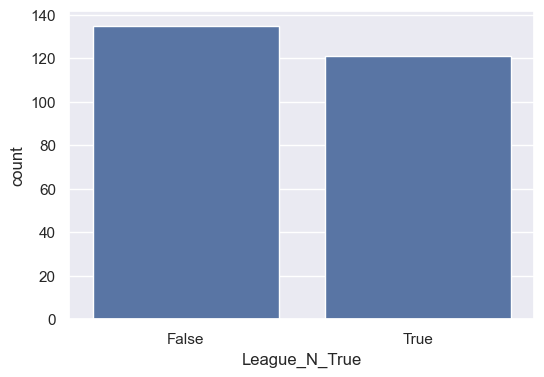

                 Division_W_True  Ratio
Division_W_True                        
True                         131 51.172
False                        125 48.828


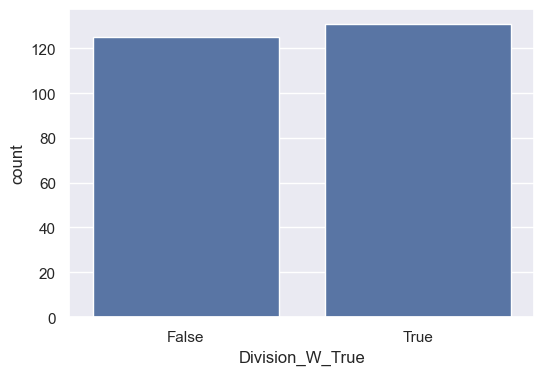

                  NewLeague_N_True  Ratio
NewLeague_N_True                         
False                          137 53.516
True                           119 46.484


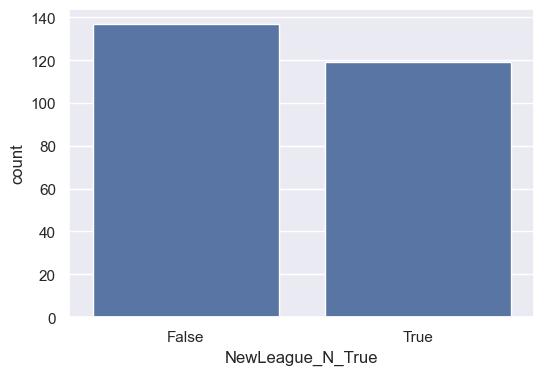

In [65]:
def cat_summary(df , col_name, plot=False):

    print(pd.DataFrame ({col_name: df [col_name].value_counts(),
                        "Ratio": 100 * df [col_name].value_counts() / len(df )}))
    
    if plot:
        plt.figure(figsize=(6, 4))
        sns.countplot(x=df [col_name], data=df )
        plt.show()

for col in cat_cols:
    cat_summary(df , col, plot=True)

Sayısal Değişken Analizi 

count   322.000
mean    380.929
std     153.405
min      16.000
5%      161.000
10%     194.100
20%     221.800
30%     281.300
40%     321.800
50%     379.500
60%     430.200
70%     490.000
80%     535.600
90%     584.900
95%     609.900
99%     658.590
max     687.000
Name: AtBat, dtype: float64


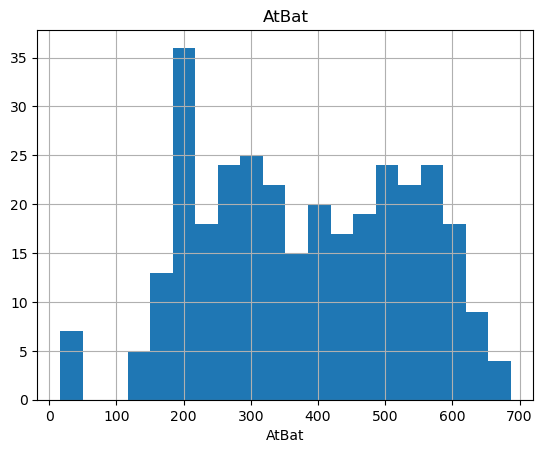

count   322.000
mean    101.025
std      46.455
min       1.000
5%       39.000
10%      45.100
20%      57.000
30%      70.000
40%      82.000
50%      96.000
60%     113.000
70%     128.700
80%     144.000
90%     163.000
95%     174.000
99%     210.790
max     238.000
Name: Hits, dtype: float64


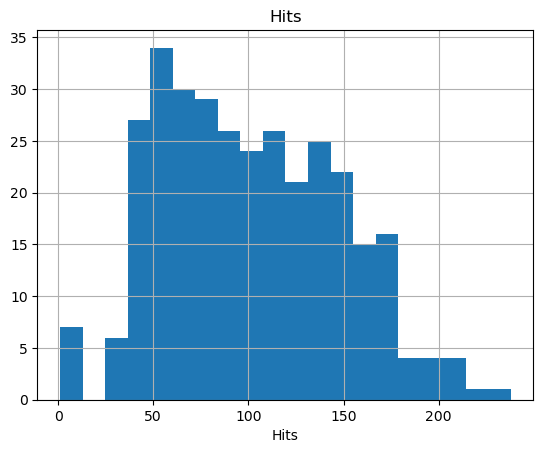

count   322.000
mean     10.770
std       8.709
min       0.000
5%        0.000
10%       1.000
20%       3.000
30%       5.000
40%       6.000
50%       8.000
60%      10.600
70%      14.000
80%      18.000
90%      24.000
95%      28.950
99%      33.000
max      40.000
Name: HmRun, dtype: float64


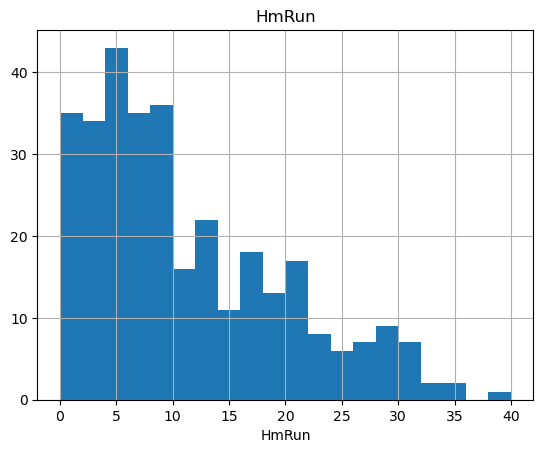

count   322.000
mean     50.910
std      26.024
min       0.000
5%       17.000
10%      20.100
20%      27.000
30%      33.000
40%      41.000
50%      48.000
60%      55.600
70%      66.000
80%      75.800
90%      89.000
95%      94.000
99%     107.790
max     130.000
Name: Runs, dtype: float64


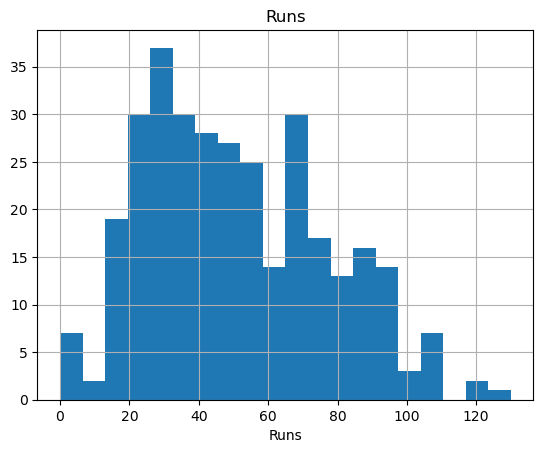

count   322.000
mean     48.028
std      26.167
min       0.000
5%       14.000
10%      19.000
20%      26.000
30%      30.000
40%      36.400
50%      44.000
60%      49.000
70%      58.000
80%      73.000
90%      86.000
95%      96.000
99%     112.370
max     121.000
Name: RBI, dtype: float64


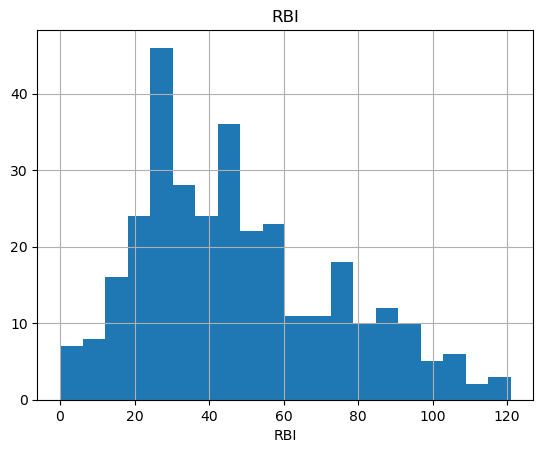

count   322.000
mean     38.742
std      21.639
min       0.000
5%       11.050
10%      15.000
20%      20.000
30%      24.000
40%      30.000
50%      35.000
60%      40.000
70%      48.700
80%      59.000
90%      69.900
95%      78.000
99%      93.580
max     105.000
Name: Walks, dtype: float64


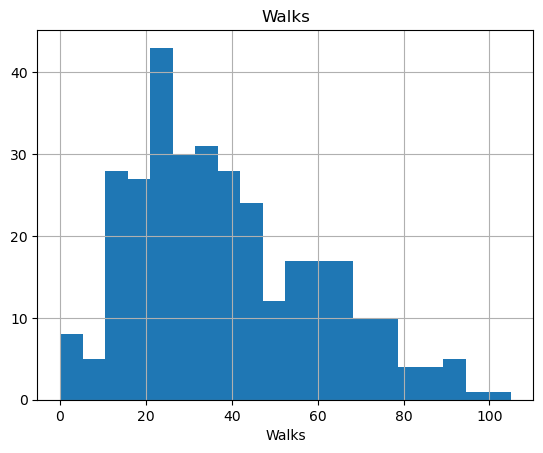

count   322.000
mean      7.444
std       4.926
min       1.000
5%        1.000
10%       2.000
20%       3.000
30%       4.000
40%       5.000
50%       6.000
60%       7.600
70%      10.000
80%      12.000
90%      15.000
95%      17.000
99%      19.790
max      24.000
Name: Years, dtype: float64


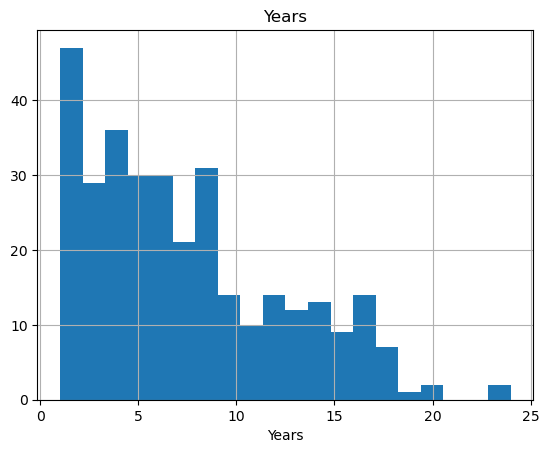

count     322.000
mean     2648.683
std      2324.206
min        19.000
5%        216.500
10%       342.200
20%       667.600
30%       963.400
40%      1402.200
50%      1928.000
60%      2654.000
70%      3365.000
80%      4483.000
90%      6123.400
95%      7125.600
99%      8749.970
max     14053.000
Name: CAtBat, dtype: float64


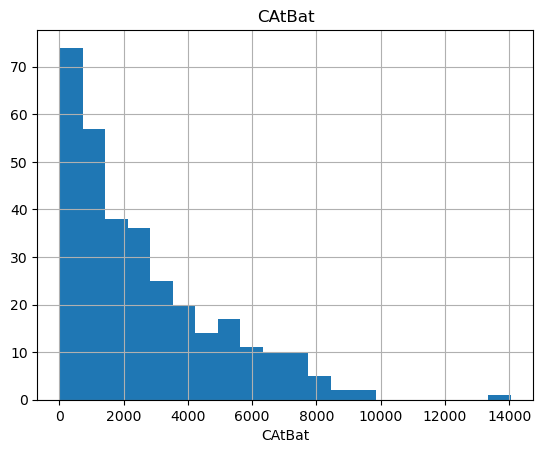

count    322.000
mean     717.571
std      654.473
min        4.000
5%        54.000
10%       86.000
20%      164.600
30%      238.000
40%      355.800
50%      508.000
60%      708.200
70%      911.100
80%     1229.200
90%     1659.600
95%     2017.150
99%     2500.340
max     4256.000
Name: CHits, dtype: float64


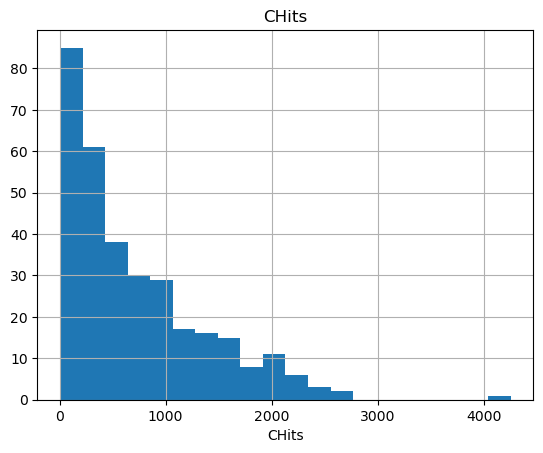

count   322.000
mean     69.491
std      86.266
min       0.000
5%        2.000
10%       4.000
20%      10.200
30%      16.300
40%      27.400
50%      37.500
60%      51.200
70%      72.400
80%     103.800
90%     194.900
95%     265.650
99%     373.120
max     548.000
Name: CHmRun, dtype: float64


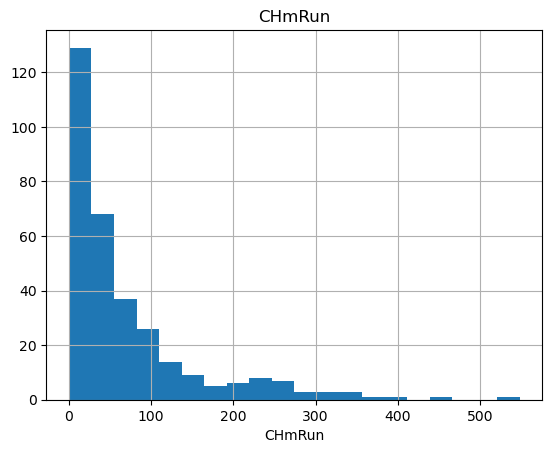

count    322.000
mean     358.795
std      334.106
min        1.000
5%        27.000
10%       38.100
20%       80.400
30%      117.300
40%      181.000
50%      247.000
60%      333.000
70%      443.400
80%      627.200
90%      895.700
95%     1032.300
99%     1174.370
max     2165.000
Name: CRuns, dtype: float64


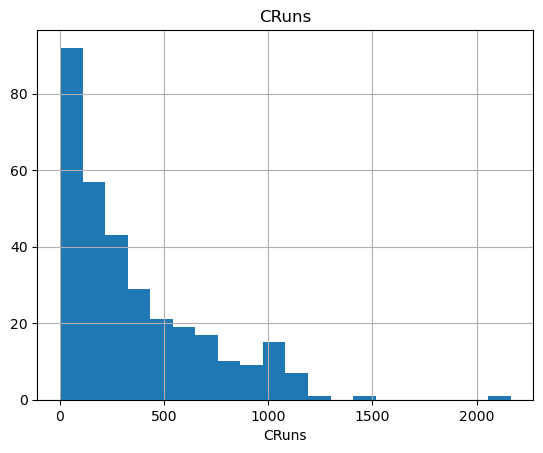

count    322.000
mean     330.118
std      333.220
min        0.000
5%        22.050
10%       34.100
20%       70.200
30%      106.300
40%      149.000
50%      220.500
60%      303.600
70%      379.100
80%      496.200
90%      861.600
95%     1071.750
99%     1310.850
max     1659.000
Name: CRBI, dtype: float64


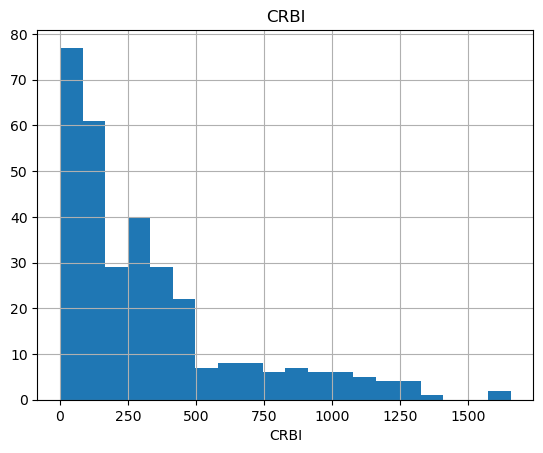

count    322.000
mean     260.239
std      267.058
min        0.000
5%        15.050
10%       30.100
20%       55.000
30%       82.000
40%      117.400
50%      170.500
60%      226.600
70%      300.700
80%      421.000
90%      643.900
95%      817.600
99%     1139.140
max     1566.000
Name: CWalks, dtype: float64


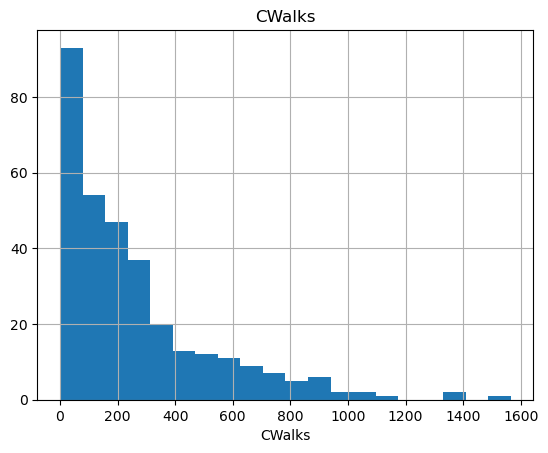

count    322.000
mean     288.938
std      280.705
min        0.000
5%        33.200
10%       62.200
20%       99.600
30%      132.000
40%      167.000
50%      212.000
60%      257.400
70%      303.000
80%      365.800
90%      685.600
95%      910.650
99%     1301.190
max     1378.000
Name: PutOuts, dtype: float64


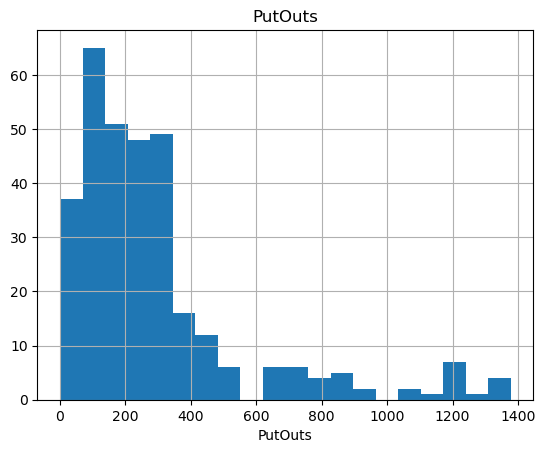

count   322.000
mean    106.913
std     136.855
min       0.000
5%        0.000
10%       2.000
20%       5.200
30%       9.000
40%      15.400
50%      39.500
60%      76.800
70%     134.800
80%     210.800
90%     353.300
95%     431.450
99%     478.160
max     492.000
Name: Assists, dtype: float64


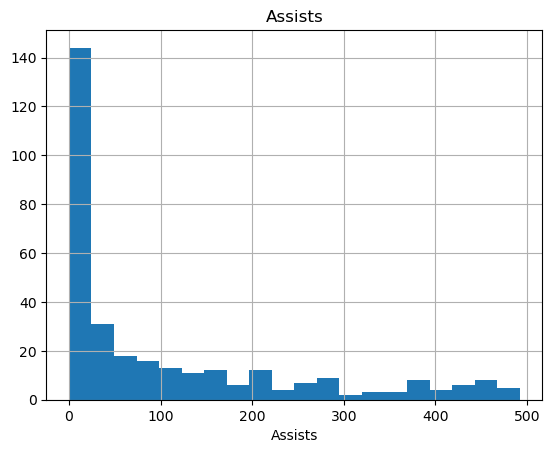

count   322.000
mean      8.040
std       6.368
min       0.000
5%        0.000
10%       1.000
20%       3.000
30%       4.000
40%       5.000
50%       6.000
60%       8.000
70%      10.000
80%      13.000
90%      17.000
95%      20.000
99%      25.790
max      32.000
Name: Errors, dtype: float64


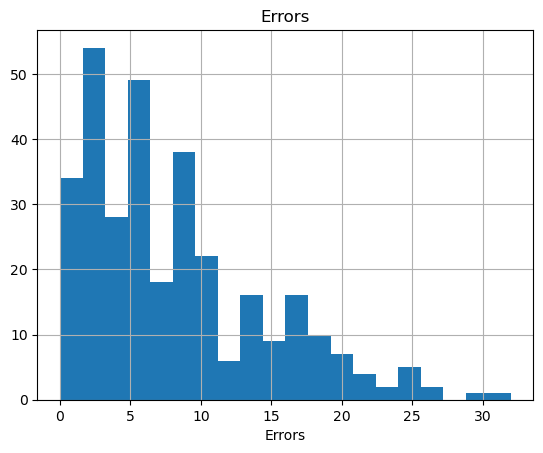

count    263.000
mean     535.926
std      451.119
min       67.500
5%        86.600
10%      100.000
20%      155.000
30%      221.000
40%      300.000
50%      425.000
60%      538.000
70%      700.000
80%      809.000
90%     1048.667
95%     1346.000
99%     2032.887
max     2460.000
Name: Salary, dtype: float64


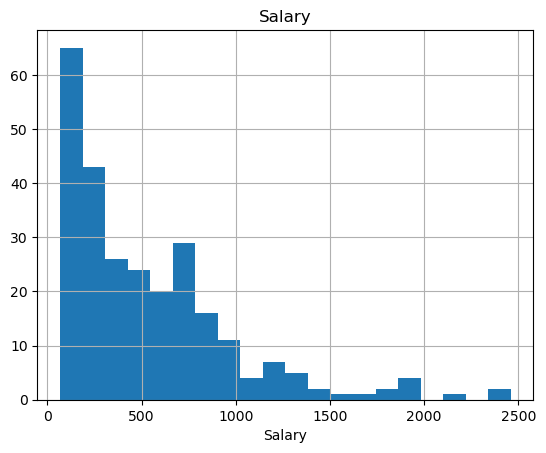

In [13]:
def num_summary(df , numerical_col, plot=False):

    quantiles = [0.05, 0.10, 0.20, 0.30, 0.40, 0.50, 0.60, 0.70, 0.80, 0.90, 0.95, 0.99]

    print(df [numerical_col].describe(quantiles).T)

    if plot:
        df [numerical_col].hist(bins=20)
        plt.xlabel(numerical_col)
        plt.title(numerical_col)
        plt.show()

for col in num_cols:
    num_summary(df, col, plot=True)

Hedef Değişken Analizi

In [24]:
def target_summary_with_cat(dataframe, target, categorical_col):

    print(pd.DataFrame({"TARGET_MEAN": dataframe.groupby(categorical_col)[target].mean()}), end="\n\n\n")

for col in cat_cols:
    target_summary_with_cat(df, "Salary", col)

        TARGET_MEAN
League             
A           542.000
N           529.118


          TARGET_MEAN
Division             
E             624.271
W             450.877


           TARGET_MEAN
NewLeague             
A              537.113
N              534.554




Korelasyon Analizi

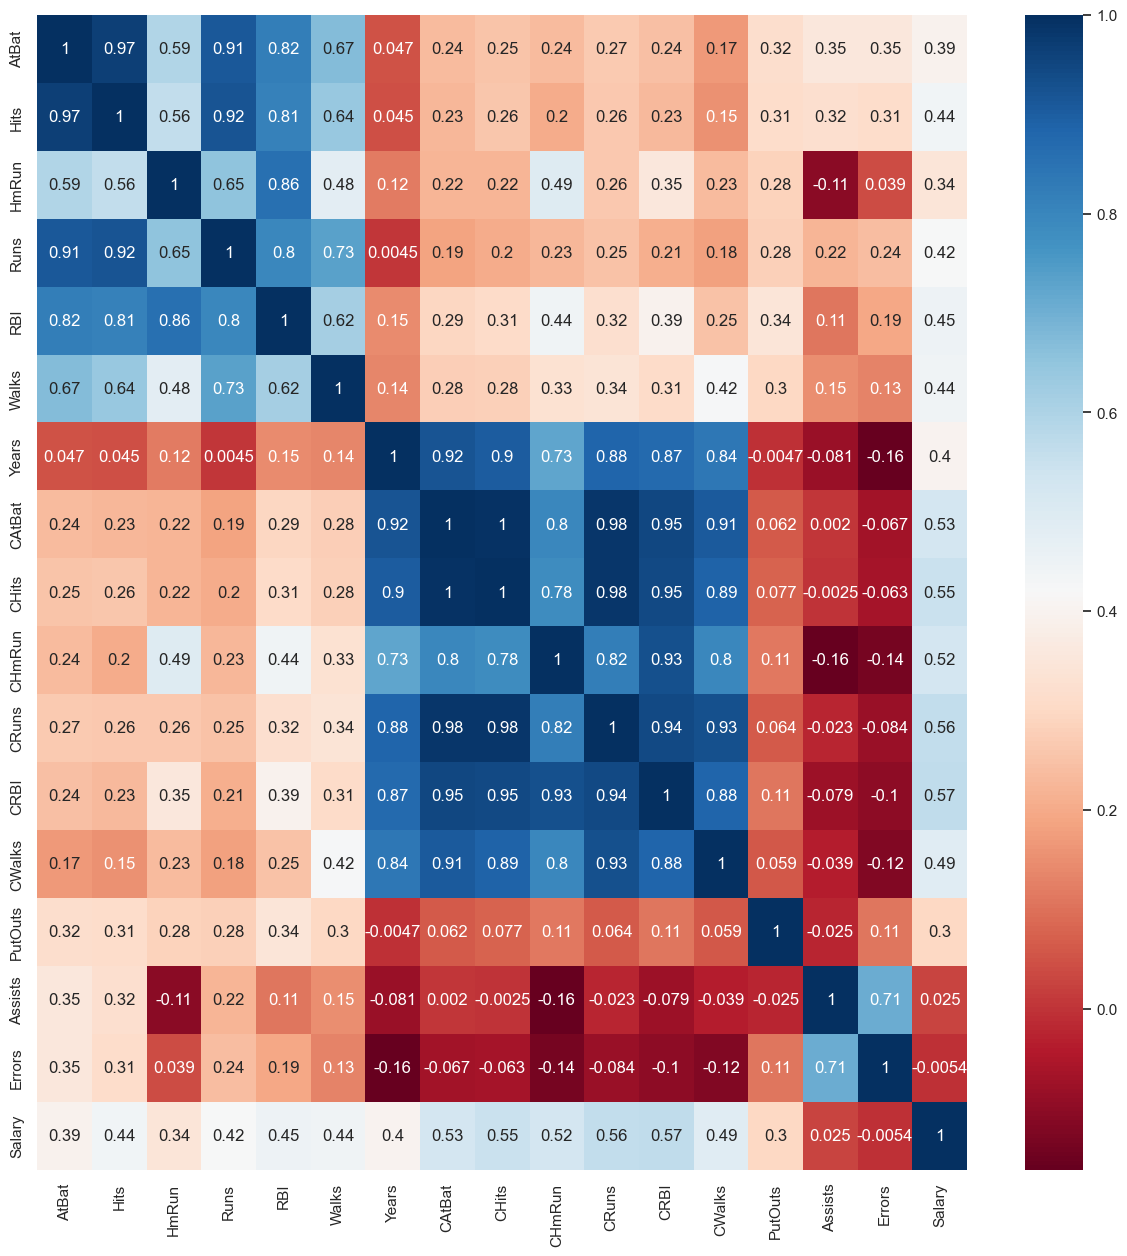

['Hits', 'Runs', 'CAtBat', 'CHits', 'CRuns', 'CRBI', 'CWalks']

In [19]:
def high_correlated_cols(df, plot=False, corr_th=0.90):
    num_df=df.select_dtypes(include=[np.number])
    corr = num_df.corr()
    cor_matrix = corr.abs()
    upper_triangle_matrix = cor_matrix.where(np.triu(np.ones(cor_matrix.shape), k=1).astype(bool))
    drop_list = [col for col in upper_triangle_matrix.columns if any(upper_triangle_matrix[col] > corr_th)]
    if plot:
        import seaborn as sns
        import matplotlib.pyplot as plt
        sns.set(rc={'figure.figsize': (15, 15)})
        sns.heatmap(corr, cmap="RdBu",annot=True)
        plt.show()
    return drop_list

high_correlated_cols(df, plot=True)

Outliers (Aykırı Değerler)

In [25]:
def outlier_thresholds(dataframe, col_name, q1=0.25, q3=0.75):
    quartile1 = dataframe[col_name].quantile(q1)
    quartile3 = dataframe[col_name].quantile(q3)
    interquantile_range = quartile3 - quartile1
    up_limit = quartile3 + 1.5 * interquantile_range
    low_limit = quartile1 - 1.5 * interquantile_range
    return low_limit, up_limit

def check_outlier(dataframe, col_name):
    low_limit, up_limit = outlier_thresholds(dataframe, col_name)
    if dataframe[(dataframe[col_name] > up_limit) | (dataframe[col_name] < low_limit)].any(axis=None):
        return True
    else:
        return False

def replace_with_thresholds(dataframe, variable):
    low_limit, up_limit = outlier_thresholds(dataframe, variable)
    dataframe.loc[(dataframe[variable] < low_limit), variable] = low_limit
    dataframe.loc[(dataframe[variable] > up_limit), variable] = up_limit

for col in num_cols:
    print(col, check_outlier(df, col))

for col in num_cols:
    if check_outlier(df, col):
        replace_with_thresholds(df, col)

AtBat False
Hits False
HmRun True
Runs True
RBI True
Walks True
Years True
CAtBat True
CHits True
CHmRun True
CRuns True
CRBI True
CWalks True
PutOuts True
Assists True
Errors True
Salary True


C:\Users\hp\AppData\Local\Temp\ipykernel_10224\3533870973.py:18: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '-27.875' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  dataframe.loc[(dataframe[variable] < low_limit), variable] = low_limit
C:\Users\hp\AppData\Local\Temp\ipykernel_10224\3533870973.py:18: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '-27.125' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  dataframe.loc[(dataframe[variable] < low_limit), variable] = low_limit
C:\Users\hp\AppData\Local\Temp\ipykernel_10224\3533870973.py:18: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '-24.5' has dtype incompatible with int64, please explicitly cast to a compatible

In [42]:
numerical_features = [col for col in num_cols if col != "Salary"] + ["Salary"]

for col in numerical_features:
    Q1 = df[col].quantile(0.10)
    Q3 = df[col].quantile(0.90)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    df = df[(df[col] >= lower_bound) & (df[col] <= upper_bound)]

In [43]:
df.shape

(256, 39)

In [44]:
df["Salary"] = np.log1p(df["Salary"])

Eksik Değer Analizi

In [45]:
def missing_values_table(dataframe, na_name=False):
    na_columns = [col for col in dataframe.columns if dataframe[col].isnull().sum() > 0]
    n_miss = dataframe[na_columns].isnull().sum().sort_values(ascending=False)
    ratio = (dataframe[na_columns].isnull().sum() / dataframe.shape[0] * 100).sort_values(ascending=False)
    missing_df = pd.concat([n_miss, np.round(ratio, 2)], axis=1, keys=['n_miss', 'ratio'])
    print(missing_df, end="\n")
    if na_name:
        return na_columns

missing_values_table(df)

df.dropna(inplace=True)

Empty DataFrame
Columns: [n_miss, ratio]
Index: []


Feature Extraction (Özellik Çıkarımı)

In [46]:
new_num_cols=[col for col in num_cols if col!="Salary"]

df[new_num_cols]=df[new_num_cols]+0.0000000001

df['NEW_Hits'] = df['Hits'] / df['CHits'] + df['Hits']
df['NEW_RBI'] = df['RBI'] / df['CRBI']
df['NEW_Walks'] = df['Walks'] / df['CWalks']
df['NEW_PutOuts'] = df['PutOuts'] * df['Years']
df["Hits_Success"] = (df["Hits"] / df["AtBat"]) * 100
df["NEW_CRBI*CATBAT"] = df['CRBI'] * df['CAtBat']
df["NEW_RBI"] = df["RBI"] / df["CRBI"]
df["NEW_Chits"] = df["CHits"] / df["Years"]
df["NEW_CHmRun"] = df["CHmRun"] * df["Years"]
df["NEW_CRuns"] = df["CRuns"] / df["Years"]
df["NEW_Chits"] = df["CHits"] * df["Years"]
df["NEW_RW"] = df["RBI"] * df["Walks"]
df["NEW_RBWALK"] = df["RBI"] / df["Walks"]
df["NEW_CH_CB"] = df["CHits"] / df["CAtBat"]
df["NEW_CHm_CAT"] = df["CHmRun"] / df["CAtBat"]
df['NEW_Diff_Atbat'] = df['AtBat'] - (df['CAtBat'] / df['Years'])
df['NEW_Diff_Hits'] = df['Hits'] - (df['CHits'] / df['Years'])
df['NEW_Diff_HmRun'] = df['HmRun'] - (df['CHmRun'] / df['Years'])
df['NEW_Diff_Runs'] = df['Runs'] - (df['CRuns'] / df['Years'])
df['NEW_Diff_RBI'] = df['RBI'] - (df['CRBI'] / df['Years'])
df['NEW_Diff_Walks'] = df['Walks'] - (df['CWalks'] / df['Years'])

One-Hot Encoding

In [47]:
def one_hot_encoder(dataframe, categorical_cols, drop_first=False):
    dataframe = pd.get_dummies(dataframe, columns=categorical_cols, drop_first=drop_first)
    return dataframe

df = one_hot_encoder(df, cat_cols, drop_first=True)
df.head()

AtBat   Hits  HmRun   Runs    RBI  Walks  Years  CAtBat  CHits  CHmRun  CRuns   CRBI  CWalks  PutOuts  Assists  Errors  Salary  NEW_Hits  NEW_RBI  NEW_Walks  \
1 -0.603 -0.596 -0.530 -1.207 -0.522 -0.097  1.409   0.373  0.201   0.110 -0.113  0.366   0.592    2.072   -0.528   0.242   6.165    -3.565   -1.427     -0.164   
2  0.513  0.492  0.738  0.442  0.795  1.615 -0.905  -0.461 -0.418   0.012 -0.425 -0.169   0.081    2.163   -0.242   0.877   6.176    -0.684   -4.702     20.056   
3  0.628  0.736  0.969  0.403  1.027 -0.189  0.778   1.369  1.413   2.305  1.518  1.898   0.496   -0.301   -0.762  -0.871   6.217     1.258    0.541     -0.382   
4 -0.562 -0.462 -0.184 -0.618 -0.367 -0.513 -1.115  -1.022 -1.002  -0.817 -0.991 -0.964  -0.969    2.163   -0.550  -0.712   4.527    -0.001    0.381      0.529   
5  1.295  1.358 -0.876  0.757 -0.019 -0.282  0.778   0.812  0.689  -0.704  0.466  0.084  -0.234    0.150    2.118   2.307   6.621     3.330   -0.222      1.202   

   NEW_PutOuts  Hits_Success  NEW_CRBI*CATBAT  NEW_Chits  NEW_CHmRun  NEW_CRuns  NEW_RW  NEW_RBWALK  NEW_CH_CB  NEW_CHm_CAT  NEW_Diff_Atbat  NEW_Diff_Hits  \
1        2.919        98.802            0.137      0.283       0.154     -0.080   0.051       5.392      0.537        0.293          -0.868         -0.738   
2       -1.958        96.043            0.078      0.379      -0.011      0.469   1.283       0.492      0.908       -0.026           0.004          0.030   
3       -0.234       117.244            2.599      1.099       1.793      1.951  -0.194      -5.424      1.032        1.683          -1.132         -1.079   
4       -2.413        82.275            0.985      1.117       0.912      0.888   0.188       0.716      0.980        0.800          -1.478         -1.360   
5        0.116       104.901            0.068      0.536      -0.547      0.599   0.005       0.066      0.848       -0.867           0.251          0.473   

   NEW_Diff_HmRun  NEW_Diff_Runs  NEW_Diff_RBI  NEW_Diff_Walks  League_N_True  Division_W_True  NewLeague_N_True  
1          -0.608         -1.127        -0.782          -0.517           True             True              True  
2           0.751         -0.027         0.608           1.704          False             True             False  
3          -1.994         -1.548        -1.413          -0.827           True            False              True  
4          -0.917         -1.506        -1.232          -1.382           True            False              True  
5           0.029          0.157        -0.127           0.020          False             True             False

Feature Scaling (Özellik Ölçeklendirme)

In [48]:
cat_cols, num_cols, cat_but_car = grab_col_names(df)

num_cols = [col for col in num_cols if col not in ["Salary"]]
scaler = StandardScaler()
df[num_cols] = scaler.fit_transform(df[num_cols])
df.head()

Observations: 256
Variables: 39
cat_cols: 3
num_cols: 36
cat_but_car: 0
num_but_cat: 3


AtBat   Hits  HmRun   Runs    RBI  Walks  Years  CAtBat  CHits  CHmRun  CRuns   CRBI  CWalks  PutOuts  Assists  Errors  Salary  NEW_Hits  NEW_RBI  NEW_Walks  \
1 -0.620 -0.613 -0.531 -1.232 -0.532 -0.108  1.547   0.434  0.250   0.142 -0.079  0.412   0.625    2.172   -0.526   0.231   6.165    -0.243   -0.301     -0.024   
2  0.511  0.484  0.744  0.430  0.803  1.624 -0.906  -0.440 -0.396   0.042 -0.403 -0.139   0.107    2.266   -0.243   0.862   6.176    -0.147   -0.621      2.682   
3  0.628  0.731  0.976  0.391  1.039 -0.202  0.878   1.478  1.513   2.382  1.616  1.992   0.528   -0.275   -0.758  -0.872   6.217    -0.081   -0.108     -0.054   
4 -0.579 -0.479 -0.184 -0.638 -0.375 -0.530 -1.129  -1.028 -1.004  -0.805 -0.992 -0.959  -0.959    2.266   -0.548  -0.714   4.527    -0.124   -0.124      0.068   
5  1.304  1.358 -0.879  0.747 -0.021 -0.295  0.878   0.894  0.759  -0.688  0.523  0.122  -0.213    0.190    2.093   2.280   6.621    -0.012   -0.183      0.158   

   NEW_PutOuts  Hits_Success  NEW_CRBI*CATBAT  NEW_Chits  NEW_CHmRun  NEW_CRuns  NEW_RW  NEW_RBWALK  NEW_CH_CB  NEW_CHm_CAT  NEW_Diff_Atbat  NEW_Diff_Hits  \
1        3.322         0.061           -0.595     -0.470      -0.469     -0.510  -0.570       0.222     -0.267       -0.110           0.045          0.098   
2       -1.988         0.058           -0.642     -0.385      -0.614     -0.254   0.823       0.079      0.008       -0.144           0.422          0.415   
3       -0.111         0.080            1.353      0.249       0.969      0.438  -0.846      -0.093      0.099        0.036          -0.069         -0.043   
4       -2.483         0.044            0.076      0.265       0.196     -0.058  -0.414       0.085      0.061       -0.057          -0.219         -0.160   
5        0.271         0.067           -0.649     -0.247      -1.084     -0.193  -0.621       0.066     -0.037       -0.233           0.529          0.599   

   NEW_Diff_HmRun  NEW_Diff_Runs  NEW_Diff_RBI  NEW_Diff_Walks  League_N_True  Division_W_True  NewLeague_N_True  
1           0.019         -0.054         0.053           0.204           True             True              True  
2           0.428          0.402         0.558           1.143          False             True             False  
3          -0.398         -0.228        -0.177           0.073           True            False              True  
4          -0.074         -0.211        -0.111          -0.161           True            False              True  
5           0.211          0.478         0.291           0.431          False             True             False

Modelleme

In [49]:
y = df["Salary"]
X = df.drop(["Salary"], axis=1)

In [50]:
models = [('LR', LinearRegression()),
          ("Ridge", Ridge()),
          ("Lasso", Lasso()),
          ("ElasticNet", ElasticNet()),
          ('KNN', KNeighborsRegressor()),
          ('CART', DecisionTreeRegressor()),
          ('RF', RandomForestRegressor()),
          ('SVR', SVR()),
          ('GBM', GradientBoostingRegressor()),
          ("XGBoost", XGBRegressor(objective='reg:squarederror')),
          ("LightGBM", LGBMRegressor()),
          ("CatBoost", CatBoostRegressor(verbose=False))]


for name, regressor in models:
    rmse = np.mean(np.sqrt(-cross_val_score(regressor, X, y, cv=10, scoring="neg_mean_squared_error")))
    print(f"RMSE: {round(rmse, 4)} ({name}) ")

RMSE: 0.4871 (LR) 
RMSE: 0.48 (Ridge) 
RMSE: 0.8726 (Lasso) 
RMSE: 0.833 (ElasticNet) 
RMSE: 0.4984 (KNN) 
RMSE: 0.5394 (CART) 
RMSE: 0.3962 (RF) 
RMSE: 0.4115 (SVR) 
RMSE: 0.4113 (GBM) 
RMSE: 0.4375 (XGBoost) 
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000230 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2393
[LightGBM] [Info] Number of data points in the train set: 230, number of used features: 38
[LightGBM] [Info] Start training from score 5.916999
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf

Random Forests

In [51]:
rf_model = RandomForestRegressor(random_state=17)

rf_params = {"max_depth": [5, 8, 15, None],
             "max_features": [5, 7, "auto"],
             "min_samples_split": [8, 15, 20],
             "n_estimators": [200, 500]}

rf_best_grid = GridSearchCV(rf_model, rf_params, cv=5, n_jobs=-1, verbose=True).fit(X, y)
rf_final = rf_model.set_params(**rf_best_grid.best_params_, random_state=17).fit(X, y)
rmse = np.mean(np.sqrt(-cross_val_score(rf_final, X, y, cv=10, scoring="neg_mean_squared_error")))
rmse

Fitting 5 folds for each of 72 candidates, totalling 360 fits


c:\Users\hp\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:547: FitFailedWarning: 
120 fits failed out of a total of 360.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
61 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\hp\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\hp\anaconda3\Lib\site-packages\sklearn\base.py", line 1467, in wrapper
    estimator._validate_params()
  File "c:\Users\hp\anaconda3\Lib\site-packages\sklearn\base.py", line 666, in _validate_params
    validate_parameter_constraints(
  File "c:\Users\hp\anaconda3\Lib\site-packages\sklearn\utils

0.39534265153454273

GBM Model

In [52]:
gbm_model = GradientBoostingRegressor(random_state=17)

gbm_params = {"learning_rate": [0.01, 0.1],
              "max_depth": [3, 8],
              "n_estimators": [500, 1000],
              "subsample": [1, 0.5, 0.7]}

gbm_best_grid = GridSearchCV(gbm_model, gbm_params, cv=5, n_jobs=-1, verbose=True).fit(X, y)
gbm_final = gbm_model.set_params(**gbm_best_grid.best_params_, random_state=17, ).fit(X, y)
rmse = np.mean(np.sqrt(-cross_val_score(gbm_final, X, y, cv=10, scoring="neg_mean_squared_error")))
rmse

Fitting 5 folds for each of 24 candidates, totalling 120 fits


0.40134721829651687

LightGBM

In [53]:
lgbm_model = LGBMRegressor(random_state=17)

lgbm_params = {"learning_rate": [0.01, 0.1],
                "n_estimators": [300, 500],
                "colsample_bytree": [0.7, 1]}

lgbm_best_grid = GridSearchCV(lgbm_model, lgbm_params, cv=5, n_jobs=-1, verbose=True).fit(X, y)
lgbm_final = lgbm_model.set_params(**lgbm_best_grid.best_params_, random_state=17).fit(X, y)
rmse = np.mean(np.sqrt(-cross_val_score(lgbm_final, X, y, cv=10, scoring="neg_mean_squared_error")))
rmse

Fitting 5 folds for each of 8 candidates, totalling 40 fits
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000378 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2623
[LightGBM] [Info] Number of data points in the train set: 256, number of used features: 38
[LightGBM] [Info] Start training from score 5.906067
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


0.3998233308571595

CatBoost

In [54]:
catboost_model = CatBoostRegressor(random_state=17, verbose=False)

catboost_params = {"iterations": [200, 500],
                   "learning_rate": [0.01, 0.1],
                   "depth": [3, 6]}

catboost_best_grid = GridSearchCV(catboost_model, catboost_params, cv=5, n_jobs=-1, verbose=True).fit(X, y)
catboost_final = catboost_model.set_params(**catboost_best_grid.best_params_, random_state=17).fit(X, y)
rmse = np.mean(np.sqrt(-cross_val_score(catboost_final, X, y, cv=10, scoring="neg_mean_squared_error")))
rmse

Fitting 5 folds for each of 8 candidates, totalling 40 fits


0.3965359703914858

Automated Hyperparameter Optimization

In [55]:
rf_params = {"max_depth": [5, 8, 15, None],
             "max_features": [5, 7, "auto"],
             "min_samples_split": [8, 15, 20],
             "n_estimators": [200, 500]}

gbm_params = {"learning_rate": [0.01, 0.1],
              "max_depth": [3, 8],
              "n_estimators": [500, 1000],
              "subsample": [1, 0.5, 0.7]}


lightgbm_params = {"learning_rate": [0.01, 0.1],
                   "n_estimators": [300, 500],
                   "colsample_bytree": [0.7, 1]}

catboost_params = {"iterations": [200, 500],
                   "learning_rate": [0.01, 0.1],
                   "depth": [3, 6]}


regressors = [("RF", RandomForestRegressor(), rf_params),
              ('GBM', GradientBoostingRegressor(), gbm_params),
              ('LightGBM', LGBMRegressor(), lightgbm_params),
              ("CatBoost", CatBoostRegressor(), catboost_params)]


best_models = {}

for name, regressor, params in regressors:
    print(f"########## {name} ##########")
    rmse = np.mean(np.sqrt(-cross_val_score(regressor, X, y, cv=10, scoring="neg_mean_squared_error")))
    print(f"RMSE: {round(rmse, 4)} ({name}) ")

    gs_best = GridSearchCV(regressor, params, cv=3, n_jobs=-1, verbose=False).fit(X, y)

    final_model = regressor.set_params(**gs_best.best_params_)
    rmse = np.mean(np.sqrt(-cross_val_score(final_model, X, y, cv=10, scoring="neg_mean_squared_error")))
    print(f"RMSE (After): {round(rmse, 4)} ({name}) ")

    print(f"{name} best params: {gs_best.best_params_}", end="\n\n")

    best_models[name] = final_model


########## RF ##########
RMSE: 0.3959 (RF) 


c:\Users\hp\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:547: FitFailedWarning: 
72 fits failed out of a total of 216.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
49 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\hp\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\hp\anaconda3\Lib\site-packages\sklearn\base.py", line 1467, in wrapper
    estimator._validate_params()
  File "c:\Users\hp\anaconda3\Lib\site-packages\sklearn\base.py", line 666, in _validate_params
    validate_parameter_constraints(
  File "c:\Users\hp\anaconda3\Lib\site-packages\sklearn\utils\

RMSE (After): 0.3897 (RF) 
RF best params: {'max_depth': None, 'max_features': 7, 'min_samples_split': 8, 'n_estimators': 200}

########## GBM ##########
RMSE: 0.4138 (GBM) 
RMSE (After): 0.3972 (GBM) 
GBM best params: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 500, 'subsample': 0.7}

########## LightGBM ##########
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000315 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2393
[LightGBM] [Info] Number of data points in the train set: 230, number of used features: 38
[LightGBM] [Info] Start training from score 5.916999
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits wi

In [58]:

best_rmse = float("inf")
best_model_name = None
best_model = None

for name, model in best_models.items():
    rmse = np.mean(np.sqrt(-cross_val_score(model, X, y, cv=10, scoring="neg_mean_squared_error")))
    print(f"{name}: RMSE = {rmse:.4f}")
    if rmse < best_rmse:
        best_rmse = rmse
        best_model_name = name
        best_model = model

print(f"\nEn iyi model: {best_model_name} (RMSE: {best_rmse:.4f})")


RF: RMSE = 0.3893
GBM: RMSE = 0.4009
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000241 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2393
[LightGBM] [Info] Number of data points in the train set: 230, number of used features: 38
[LightGBM] [Info] Start training from score 5.916999
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No

In [ ]:
from scipy import stats


from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


best_model_rf = best_models["RF"]
best_model_rf.fit(X_train, y_train)


y_pred = best_model_rf.predict(X_test)

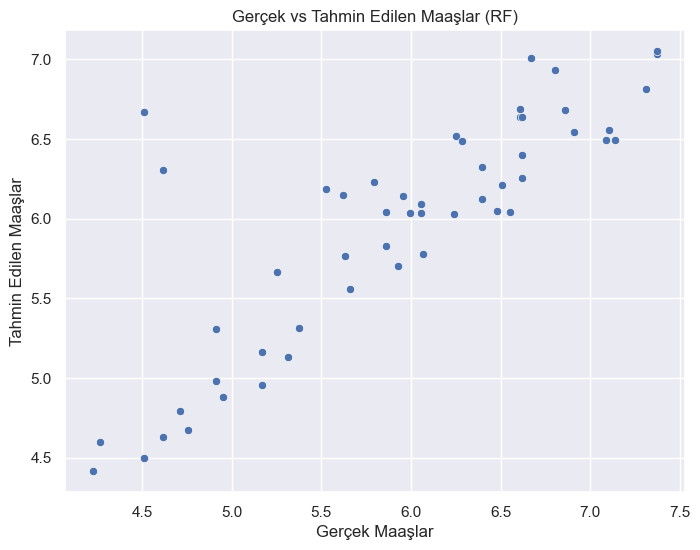

In [60]:
plt.figure(figsize=(8,6))
sns.scatterplot(x=y_test, y=y_pred)
plt.xlabel("Gerçek Maaşlar")
plt.ylabel("Tahmin Edilen Maaşlar")
plt.title("Gerçek vs Tahmin Edilen Maaşlar (RF)")
plt.show()

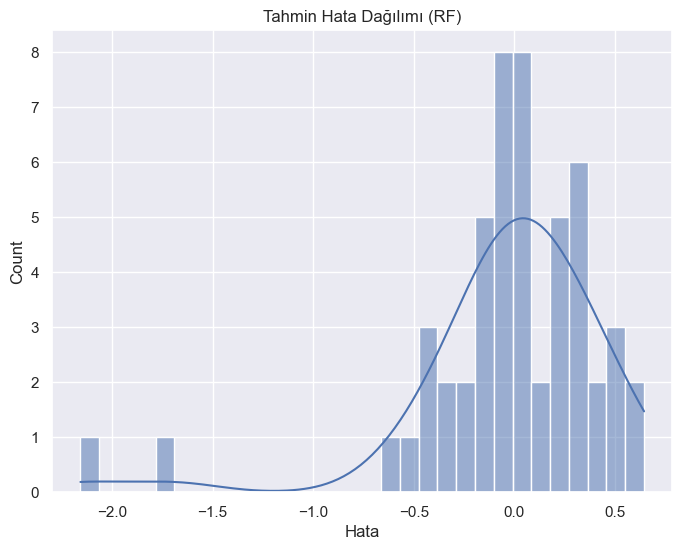

In [61]:
errors = y_test - y_pred
plt.figure(figsize=(8,6))
sns.histplot(errors, kde=True, bins=30)
plt.xlabel("Hata")
plt.title("Tahmin Hata Dağılımı (RF)")
plt.show()

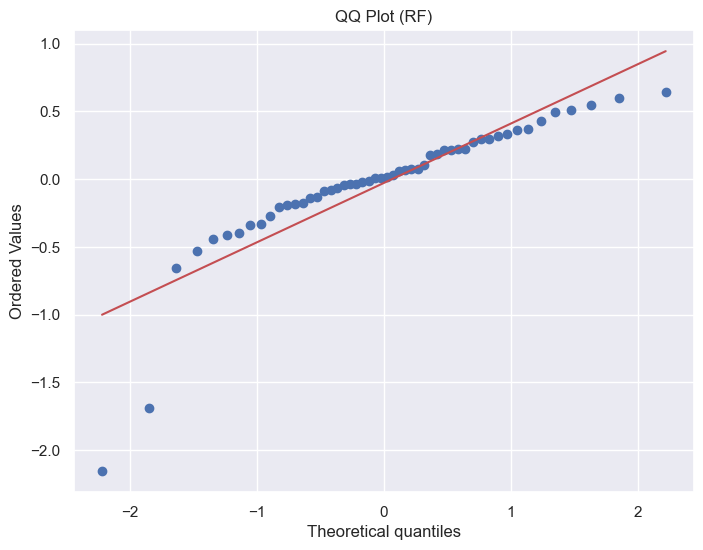

In [62]:
plt.figure(figsize=(8,6))
stats.probplot(errors, dist="norm", plot=plt)
plt.title("QQ Plot (RF)")
plt.show()

Feature Importance

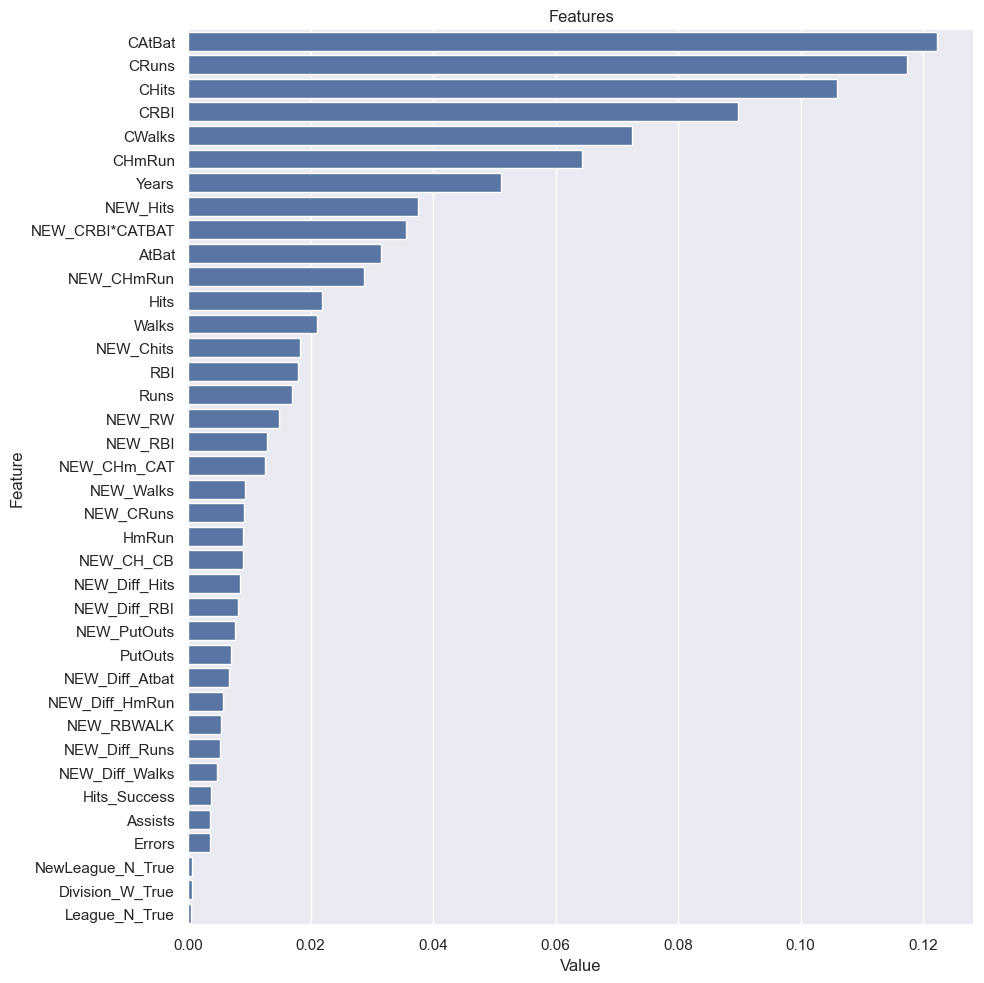

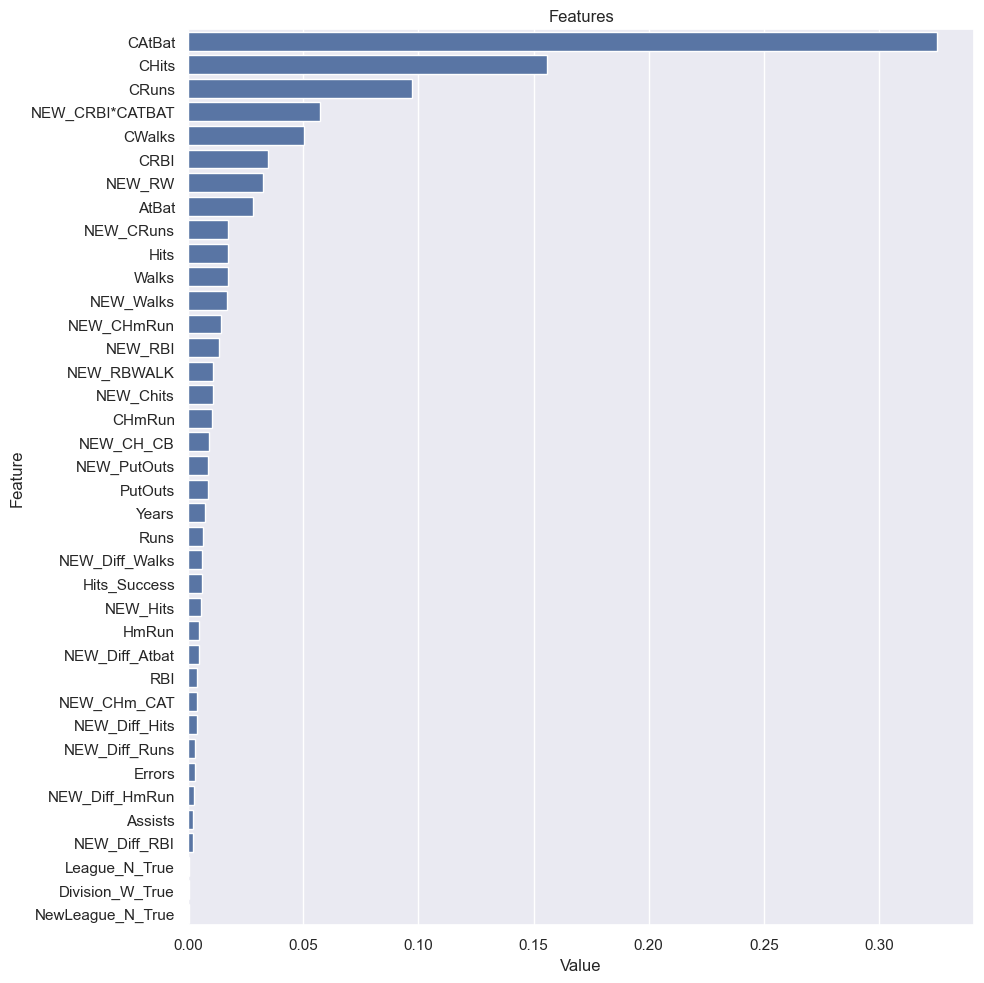

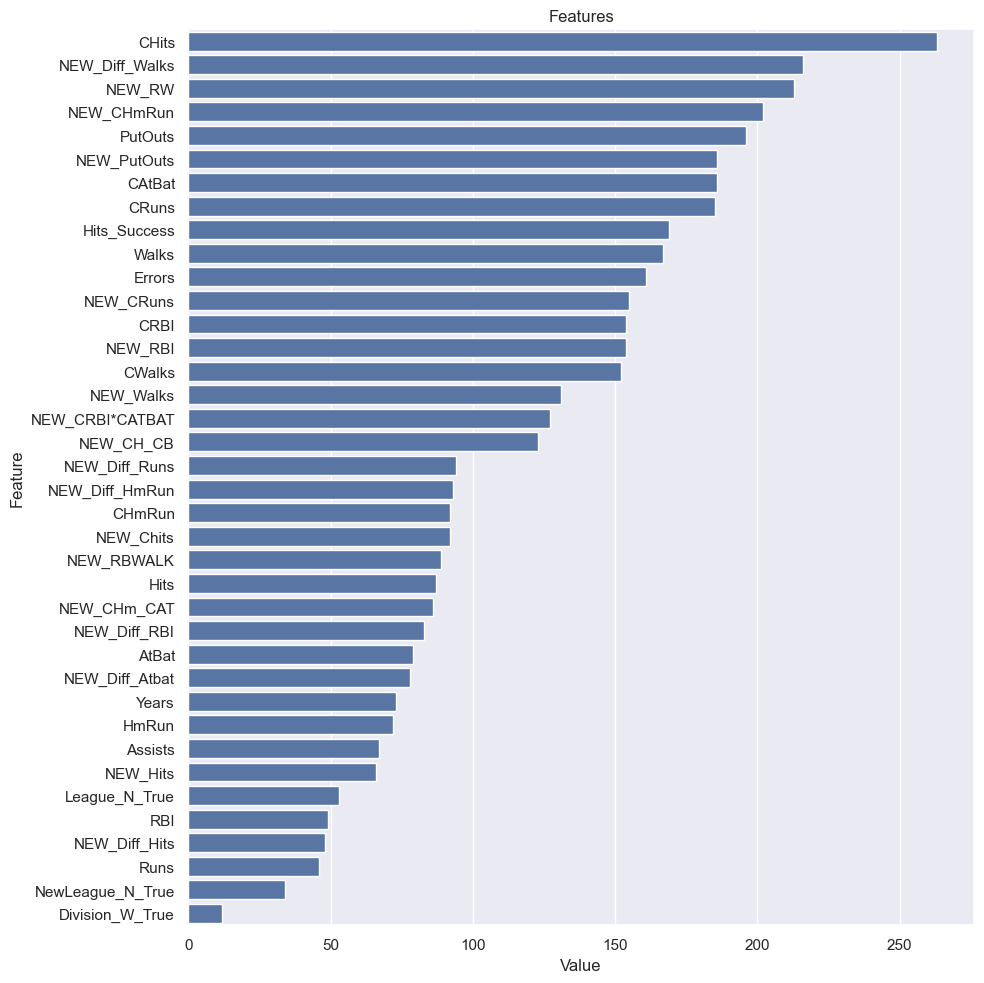

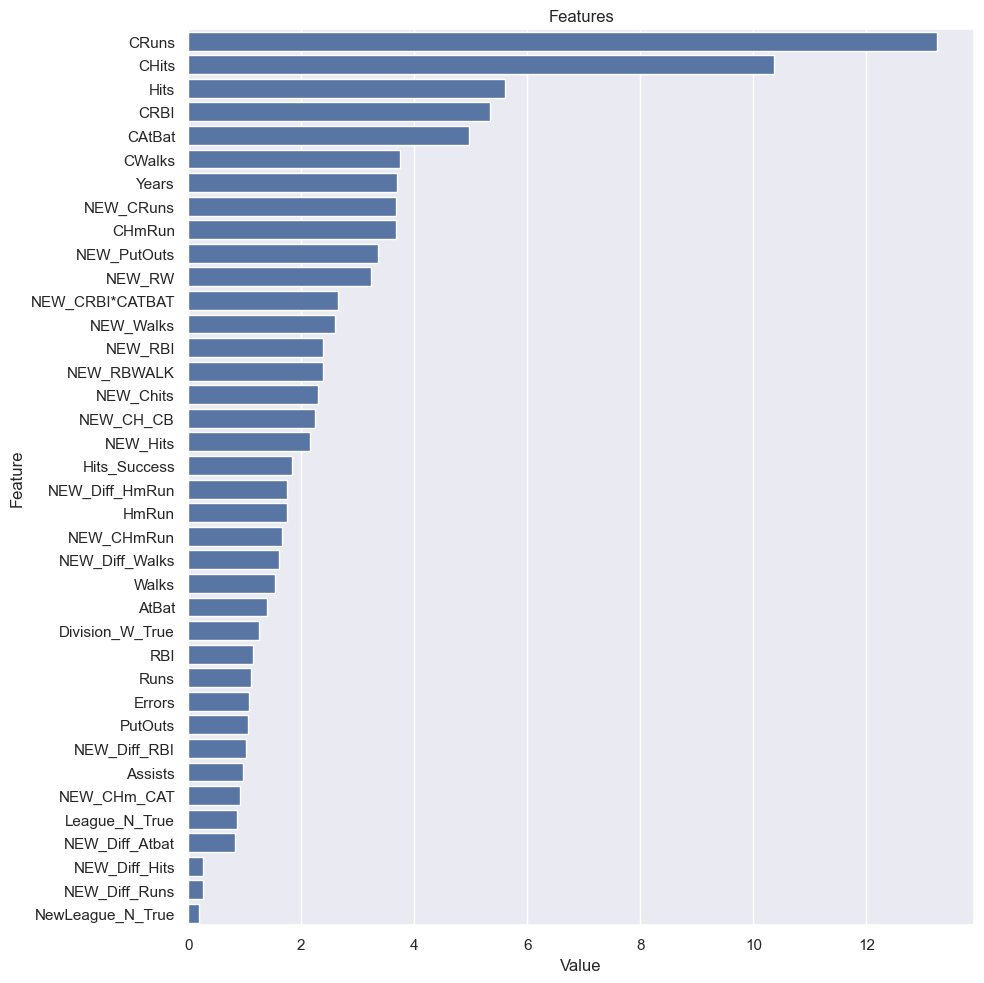

In [63]:
def plot_importance(model, features, num=len(X), save=False):
    feature_imp = pd.DataFrame({'Value': model.feature_importances_, 'Feature': features.columns})
    plt.figure(figsize=(10, 10))
    sns.set(font_scale=1)
    sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value",
                                                                     ascending=False)[0:num])
    plt.title('Features')
    plt.tight_layout()
    plt.show()
    if save:
        plt.savefig('importances.png')


plot_importance(rf_final, X)
plot_importance(gbm_final, X)
plot_importance(lgbm_final, X)
plot_importance(catboost_final, X)